In [1]:
import torch
import torchvision
import os
import tarfile#when working with archives and tar archives
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
project_name="cifar-10-cnn-model"

In [3]:
dataset_url="http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url,'.')

In [4]:
#Extract from archive
with tarfile.open('./cifar10.tgz','r:gz') as tar:
    tar.extractall(path='./data')

The dataset is extracted to the directory data/cifar10. It contains 2 folders train and test, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using os.listdir.

In [5]:
data_dir='./data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['labels.txt', 'train', 'test']
['deer', 'cat', 'horse', 'frog', 'bird', 'airplane', 'ship', 'truck', 'dog', 'automobile']


Let's look inside a couple of folders, one from the training set and another from the test set. As an exercise, you can verify that that there are an equal number of images for each class, 5000 in the training set and 1000 in the test set.

In [6]:
#Train set
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['5266_airplane.png', '18808_airplane.png', '3536_airplane.png', '43184_airplane.png', '38179_airplane.png']


In [7]:
#Test Set
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['8607_ship.png', '5770_ship.png', '8883_ship.png', '1286_ship.png', '9787_ship.png']


The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the ImageFolder class from torchvision to load the data as PyTorch tensors.

In [8]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [9]:
#To merge all training examples into a single  training dataset
dataset=ImageFolder(data_dir+'/train',transform=ToTensor())

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape (3, 32, 32)

In [10]:
img,label=dataset[0]
print(img.shape)

torch.Size([3, 32, 32])


In [11]:
classes=dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's look few images of our dataset

Label (numeric): 0
Label (textual): airplane


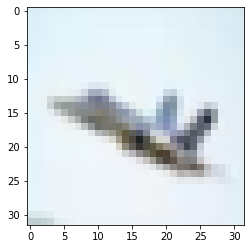

In [12]:
#we use permute beacuse  in whenever we're printing an image using matplotlib ,we want colour channel to be in 3rd dimension and here its in 1st
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))#that's why .permute just permute the dimensions
print('Label (numeric):', label)
print('Label (textual):', classes[label])

Label (numeric): 2
Label (textual): bird


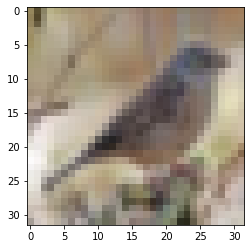

In [13]:
img, label = dataset[10000]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

Label (numeric): 7
Label (textual): horse


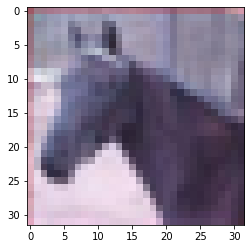

In [14]:
img, label = dataset[37890]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [15]:
# Dividing dataset into training and validation set
random_seed=40
torch.manual_seed(random_seed);

In [16]:
val_size=5000
train_size=len(dataset)-val_size
train,val=random_split(dataset,[train_size,val_size])
len(train),len(val)

(45000, 5000)

In [17]:
from torch.utils.data.dataloader import DataLoader
batch_size=128

In [18]:
train_loader=DataLoader(train,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val,batch_size*2,num_workers=4,pin_memory=True)

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


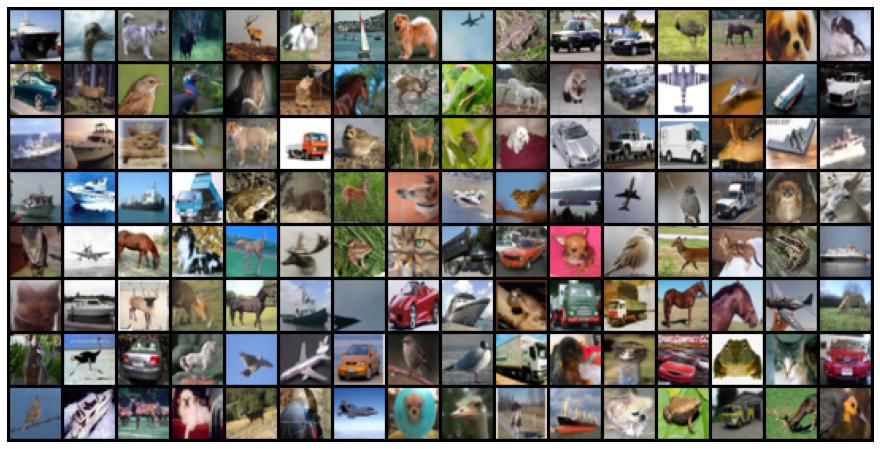

In [19]:
from torchvision.utils import make_grid
for images,_ in train_loader:
    plt.figure(figsize=(18,8))
    plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
    plt.axis('off')
    break

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
#That's an simple structure of our Cnn model 
#Here 3 s the input channels and is is the chanel oftputs
simple_model=nn.Sequential(nn.Conv2d(3,12,kernel_size=3,stride=1,padding=1),nn.MaxPool2d(2,2))#output- 12 * 16 * 16

In [22]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 12, 16, 16])


In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# Archietecture of Cnn Model

In [24]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),#output- 64 * 16 * 16
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),# output- 256 * 8 * 8
            
            nn.Flatten(),
            nn.Linear(256*8*8,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,10))
        
    def forward(self, xb):
        return self.network(xb)

In [25]:
model=Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten()
    (11): Linear(in_features=16384, out_features=1024, bias=True)
    (12): ReLU()
    (13): Linear(in_features=1024, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [26]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0398,  0.0297,  0.0136,  0.0193, -0.0323, -0.0371,  0.0019,  0.0010,
        -0.0301, -0.0315], grad_fn=<SelectBackward>)


Moving all the data and Model into GPU

In [27]:
torch.cuda.is_available()

True

In [28]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [29]:
device=get_default_device()
device

device(type='cuda')

In [30]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
to_device(model, device);

# Training our Model

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [32]:
model = to_device(Cifar10CnnModel(), device)

In [33]:
evaluate(model, val_loader)

{'val_loss': 2.3025238513946533, 'val_acc': 0.09935661405324936}

In [34]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [35]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)


Epoch [0], train_loss: 1.6120, val_loss: 1.2188, val_acc: 0.5549
Epoch [1], train_loss: 1.0459, val_loss: 0.9378, val_acc: 0.6689
Epoch [2], train_loss: 0.7615, val_loss: 0.7689, val_acc: 0.7296
Epoch [3], train_loss: 0.5557, val_loss: 0.7213, val_acc: 0.7503
Epoch [4], train_loss: 0.3560, val_loss: 0.8536, val_acc: 0.7516
Epoch [5], train_loss: 0.2026, val_loss: 1.0058, val_acc: 0.7411
Epoch [6], train_loss: 0.1218, val_loss: 1.1121, val_acc: 0.7422
Epoch [7], train_loss: 0.0744, val_loss: 1.3369, val_acc: 0.7309
Epoch [8], train_loss: 0.0656, val_loss: 1.2521, val_acc: 0.7420
Epoch [9], train_loss: 0.0516, val_loss: 1.4416, val_acc: 0.7385


In [36]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

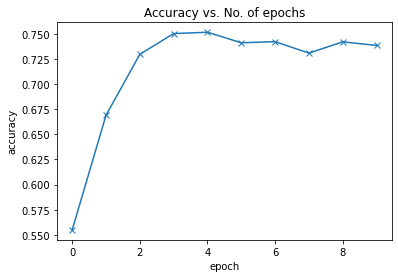

In [37]:
plot_accuracies(history)

In [38]:
def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

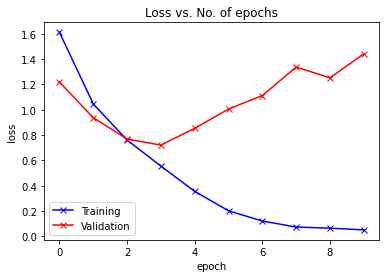

In [39]:
plot_losses(history)

> As we can clearly see that after a certain point our val_loss is increasing but our training set is still decreasing
> This is due to the problem of overfitting,which we can improve further\

Now lets check our model to predict some images of test dataset

In [40]:
test_dataset=ImageFolder(data_dir+'/test',transform=ToTensor())

In [41]:
def predict_image(img,model):
    # Convert to a batch of 1
    xb=to_device(img.unsqueeze(0),device)
    # Get predictions from model
    yb=model(xb)
    #pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


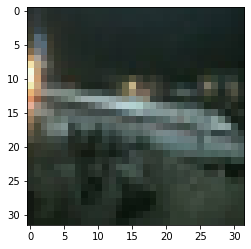

In [42]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: airplane


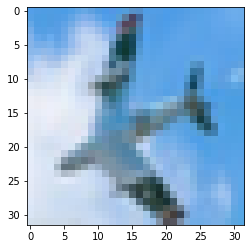

In [43]:
img, label = test_dataset[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: deer , Predicted: deer


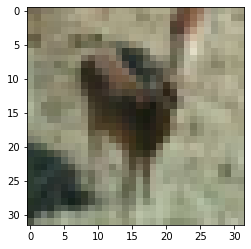

In [44]:
img, label = test_dataset[4670]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: bird , Predicted: ship


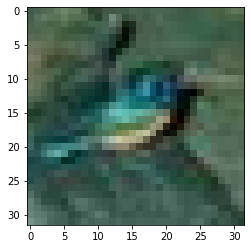

In [45]:
img, label = test_dataset[2450]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

We can see clearly that,most of our predictions are correct but some are no,.Basically it's because out model has an accuracy of around 75%

In [46]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.3875216245651245, 'val_acc': 0.7421875}